In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize


In [3]:
def load_combined_dataset(json_path):
    """
    Reads the combined dataset JSON and returns it as a Python list of dicts.
    Each item has: { "tokens": [...], "ner_tags": [...], "intent": "..." }
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

1. Load & Prepare the Data

In [4]:
combined_dataset_path = "/Users/mertcoskuner/Desktop/CS445_Project/experiments/baseline/train_test_split/train_combined.json"
data = load_combined_dataset(combined_dataset_path)

# Convert to DataFrame
df = pd.DataFrame(data)
# df has columns: "tokens", "ner_tags", "intent"
# Create a "text" column by joining tokens
df["text"] = df["tokens"].apply(lambda ts: " ".join(ts))
# Create a "entity_text" column by joining the NER tags
df["entity_text"] = df["ner_tags"].apply(lambda tags: " ".join(tags))
# label
y_intent = df["intent"]

2. Build a Feature Pipeline

In [5]:
text_tfidf = ("text_tfidf", TfidfVectorizer(), "text")
entity_tfidf = ("entity_tfidf", TfidfVectorizer(), "entity_text")

feature_union = ColumnTransformer(
    [text_tfidf, entity_tfidf],
    remainder="drop"
)

pipeline = Pipeline([
    ("features", feature_union),
    ("clf", LogisticRegression())
])

3. Train/Test Split & Fit

In [6]:
# First split: 75% training and 25% remaining
X_train, X_temp, y_train, y_temp = train_test_split(
    df, y_intent, test_size=0.25, random_state=42
)

# Second split: Split the remaining 25% into 10% validation and 15% testing
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.6, random_state=42  # 60% of 25% = 15%
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('text_tfidf',
                                                  TfidfVectorizer(), 'text'),
                                                 ('entity_tfidf',
                                                  TfidfVectorizer(),
                                                  'entity_text')])),
                ('clf', LogisticRegression())])

4. Classification Report:

In [7]:
y_pred = pipeline.predict(X_test)
# Print the classification report (includes per-class F1)
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Print the overall F1 score (macro average)
macro_f1 = f1_score(y_test, y_pred, average="macro")
print(f"Overall Macro F1 Score: {macro_f1:.3f}")

Classification Report:
                           precision    recall  f1-score   support

             abbreviation       0.80      0.89      0.84        18
                 aircraft       0.88      0.78      0.82         9
aircraft+flight+flight_no       0.00      0.00      0.00         1
                  airfare       0.95      0.88      0.92        68
                  airline       0.95      0.69      0.80        29
                  airport       1.00      0.33      0.50         3
                 capacity       1.00      1.00      1.00         3
                     city       0.00      0.00      0.00         4
                 distance       1.00      1.00      1.00         1
                   flight       0.94      0.99      0.96       554
           flight+airfare       0.00      0.00      0.00         4
                flight_no       0.00      0.00      0.00         3
              flight_time       0.57      0.57      0.57         7
              ground_fare       0.00  

/Users/mertcoskuner/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mertcoskuner/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mertcoskuner/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

5.Confusion Matrix

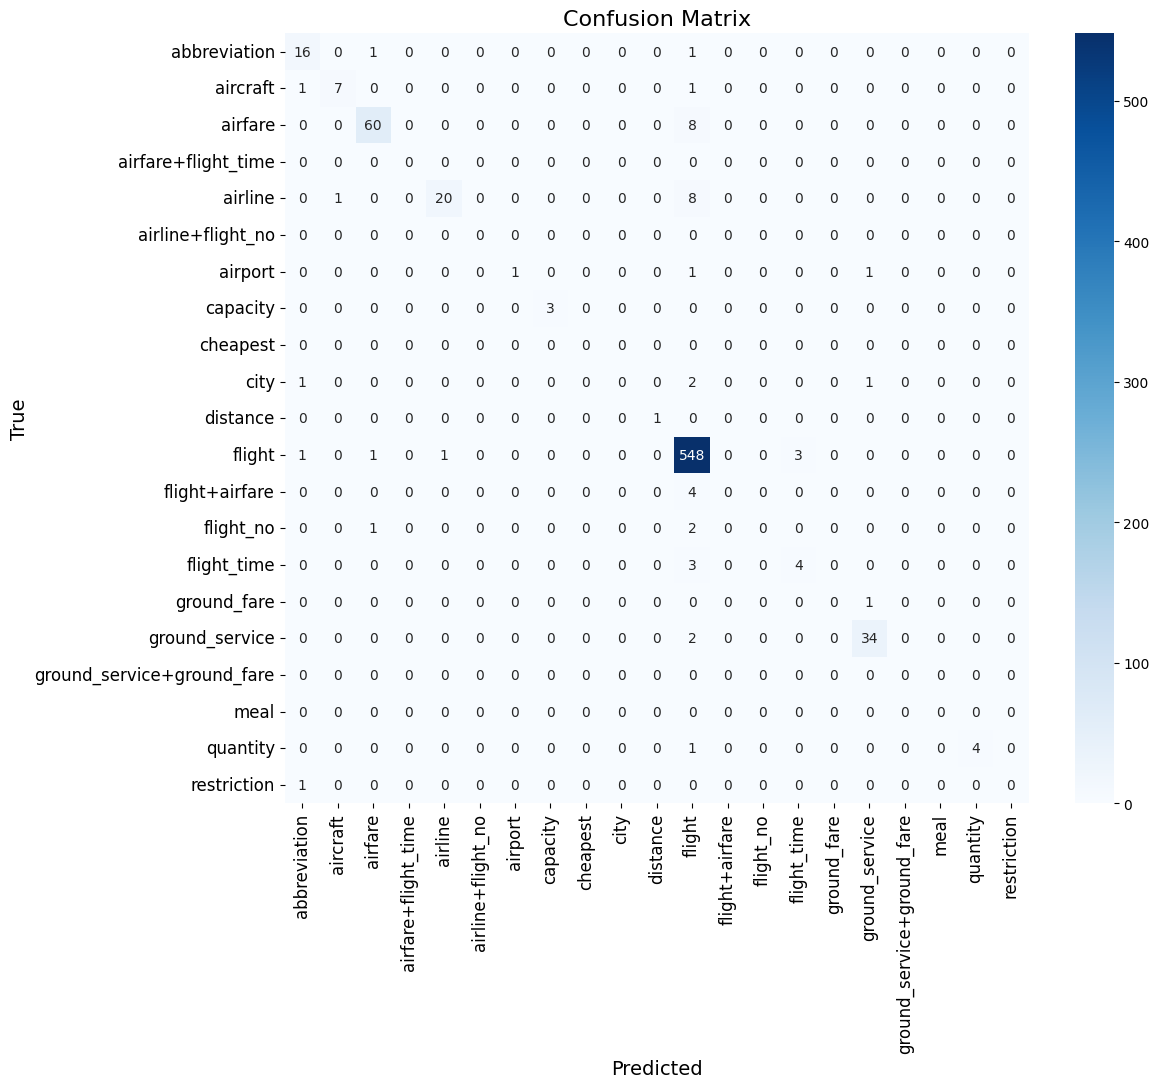

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
plt.figure(figsize=(12, 10))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

6.Precision-Recall Curves

/Users/mertcoskuner/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


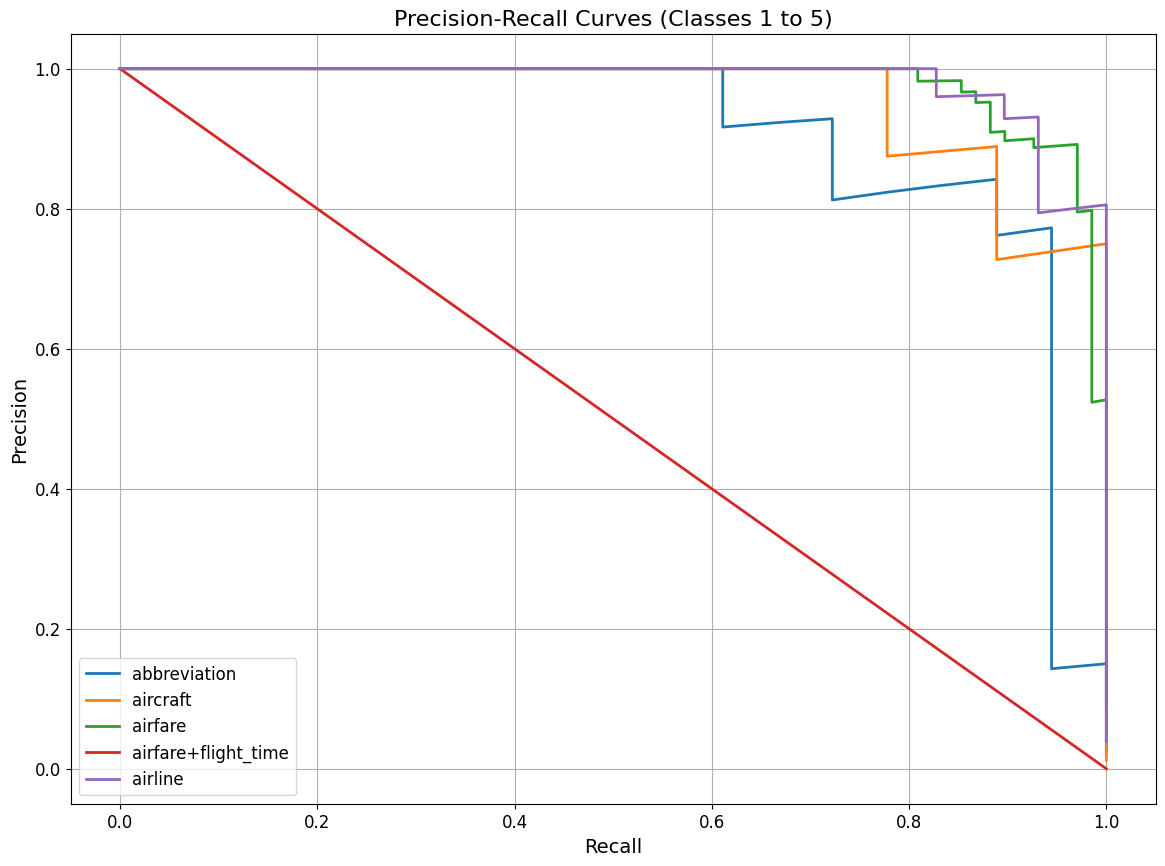

/Users/mertcoskuner/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/mertcoskuner/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


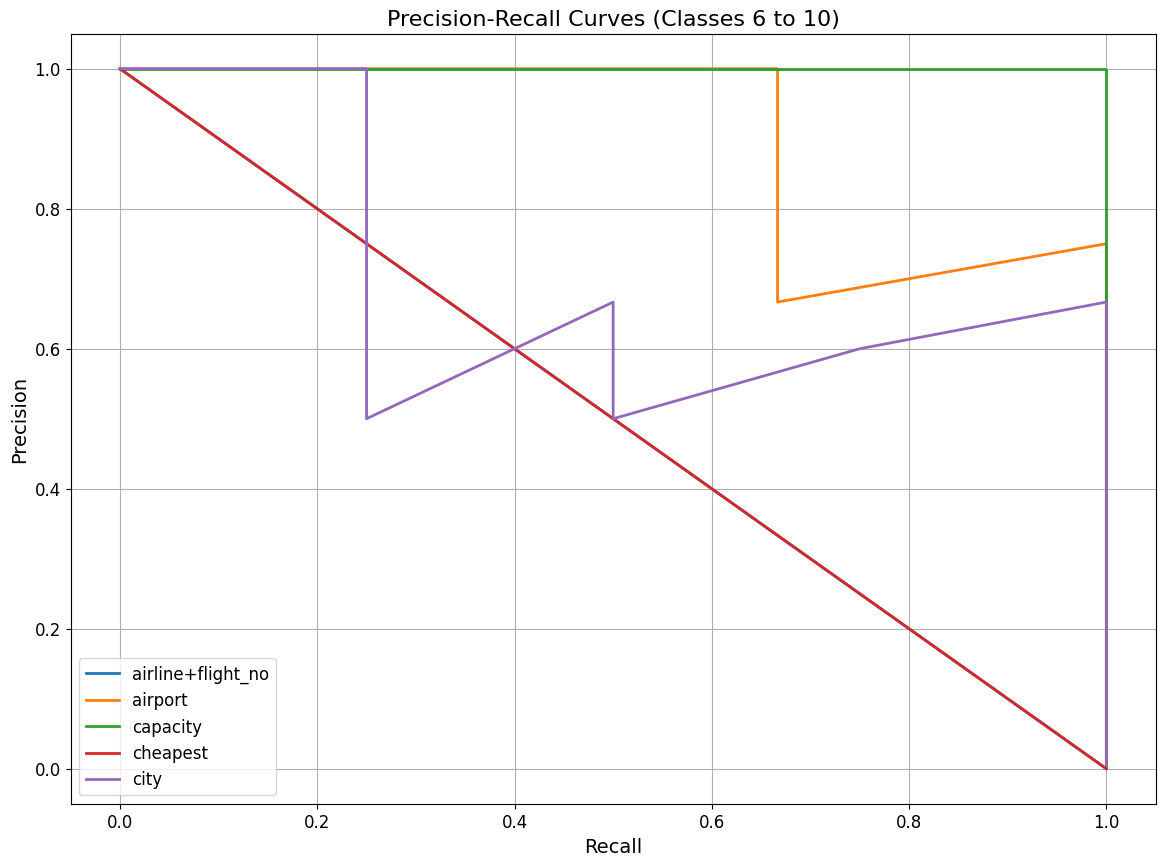

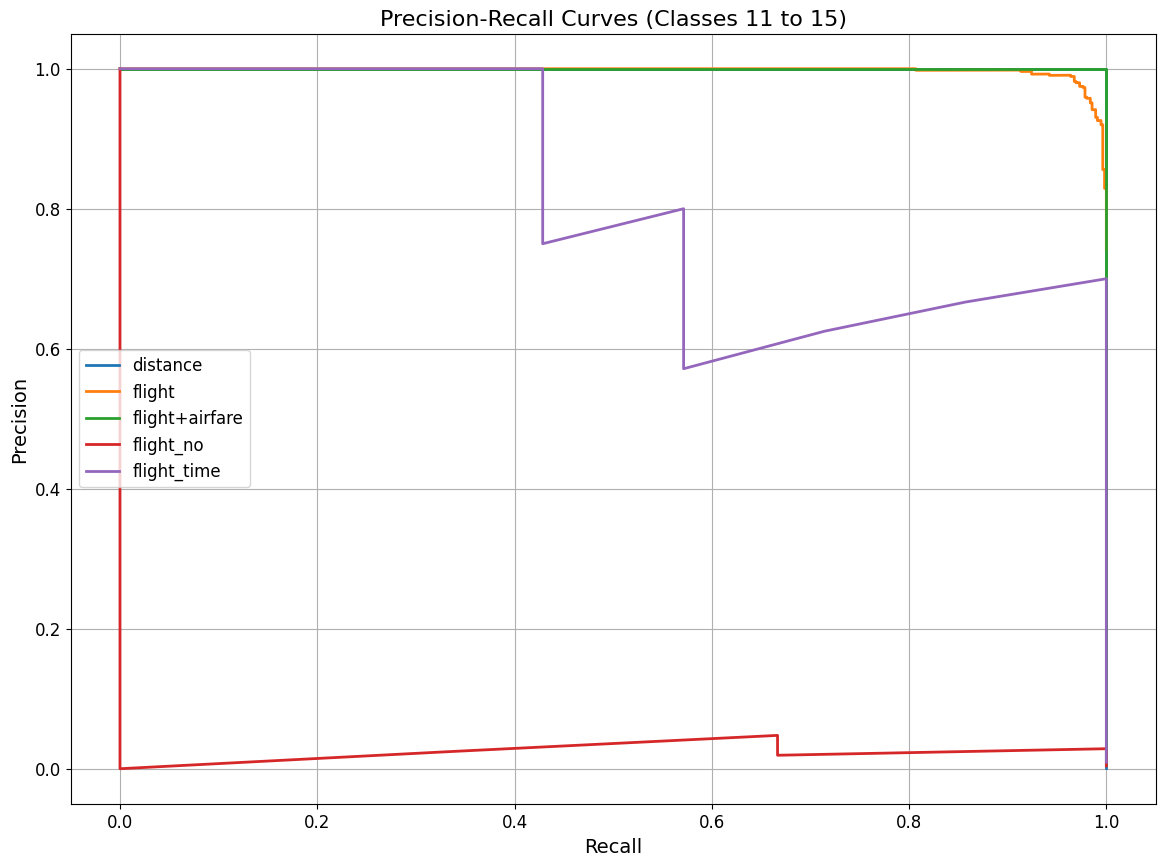

/Users/mertcoskuner/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/mertcoskuner/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


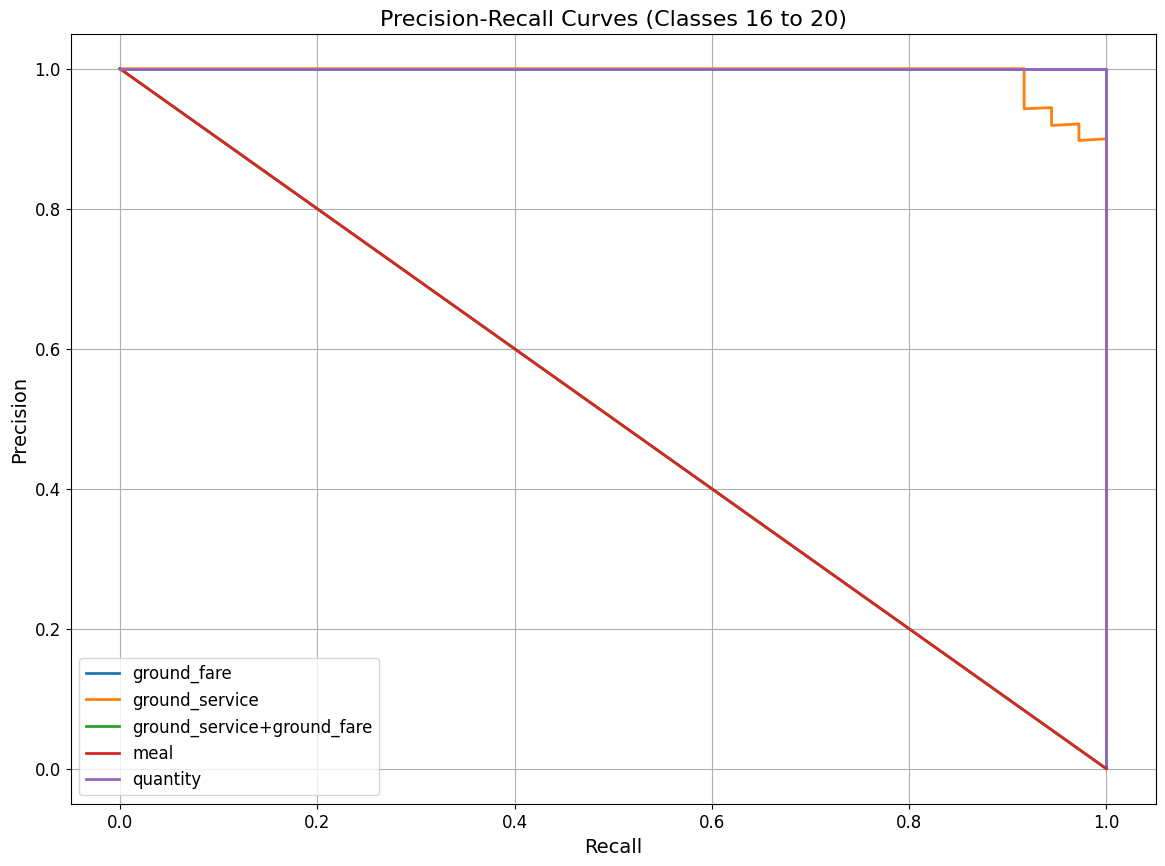

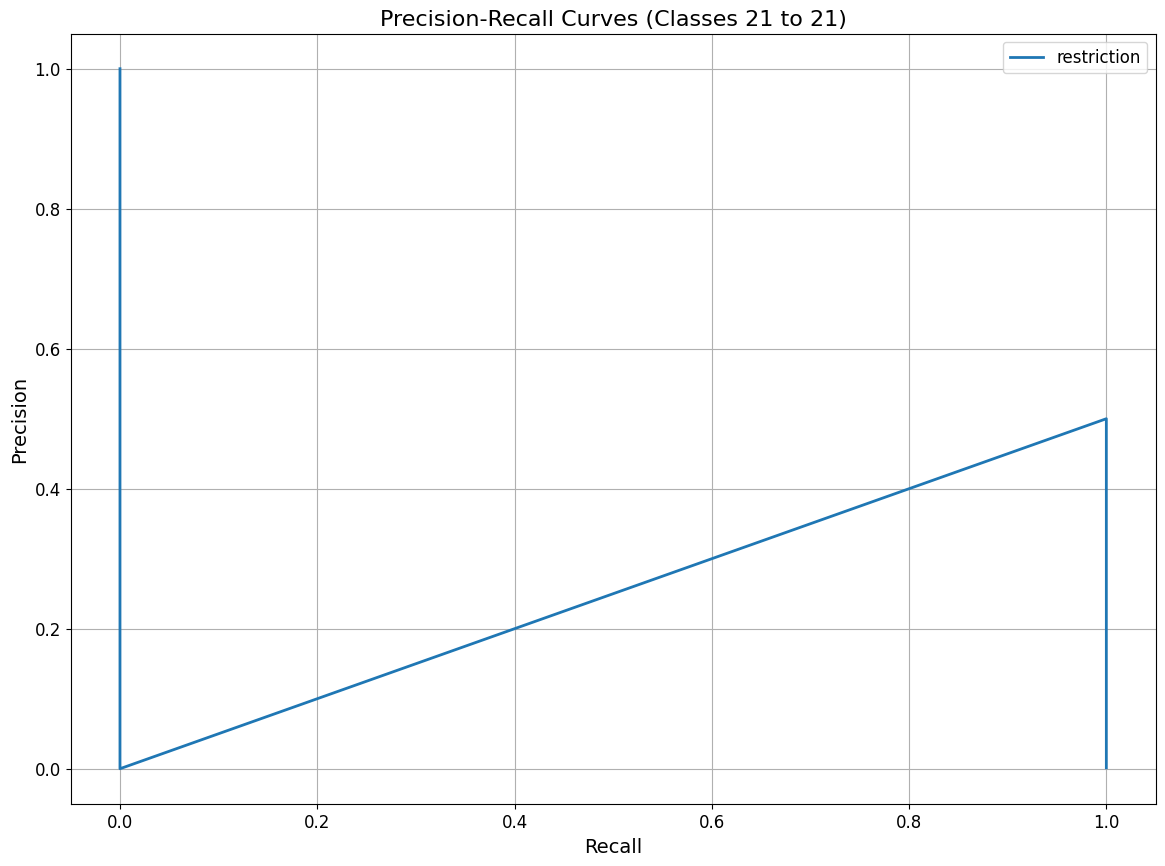

In [9]:
import math
y_test_bin = label_binarize(y_test, classes=pipeline.classes_)
y_pred_prob = pipeline.predict_proba(X_test)
# Precision-Recall Curves - Split into multiple plots
n_classes = len(pipeline.classes_)  # Total number of classes
classes_per_plot = 5  # Number of classes per plot
n_plots = math.ceil(n_classes / classes_per_plot)  # Number of plots needed

for plot_idx in range(n_plots):
    start_idx = plot_idx * classes_per_plot
    end_idx = min(start_idx + classes_per_plot, n_classes)  

    plt.figure(figsize=(14, 10))
    for i in range(start_idx, end_idx):
        class_name = pipeline.classes_[i]
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(recall, precision, label=class_name, linewidth=2)

    plt.title(f"Precision-Recall Curves (Classes {start_idx+1} to {end_idx})", fontsize=16)
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()